### Import Libraries and Dataset

In [3]:
from Functions import get_feature_ranking, RMSE, train_model, wrapper_feature_selector 
from pyspark import SparkContext
from spark_sklearn import GridSearchCV
from pylab import *

import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from time import time
from math import sqrt
from xgboost import XGBRegressor

from matplotlib import pyplot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

# Import train + test features (after data processing)
data = pd.read_csv('Trees_features.csv')
print('n_features:', len(data.iloc[0]))
print('n_samples:', len(data))
#data = data.iloc[:,1:]
data.head()

n_features: 23
n_samples: 953


,Id,accommodates,bathrooms,bedrooms,beds,cleaning_fee,minimum_nights,number_of_reviews,review_scores_location,instant_bookable,...,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,area_Manly,area_Pittwater,area_Warringah
0,570,0.052367,-0.577122,0.141696,-0.206717,-0.881690,-0.234696,-0.436781,0.90309,0,...,0,1,0,0,1,0,0,0,0,1
1,571,-0.690463,-0.577122,-0.827405,-0.901215,-0.178438,-0.234696,0.170065,1.00000,0,...,0,0,1,0,1,0,0,1,0,0
2,572,0.052367,-0.577122,-0.827405,-0.206717,-0.881690,0.205502,-0.436781,1.00000,0,...,0,1,0,0,0,0,1,0,0,1
3,573,-0.319048,-0.577122,0.141696,-0.901215,-0.037788,-0.322735,-0.301927,0.90309,0,...,0,1,0,0,0,0,1,1,0,0
4,574,0.052367,-0.577122,0.141696,-0.206717,-0.881690,-0.146656,-0.504209,1.00000,0,...,0,1,0,0,0,1,0,0,0,1


In [4]:
# Import train labels
Y_train = pd.read_csv('Trees_labels.csv')
print('n_samples:', len(Y_train))
Y_train = Y_train.iloc[:,1].values

n_samples: 383


In [5]:
# Split training and test data
train_data  = data.iloc[:383,1:]
X_train = train_data.values
test_data = data.iloc[383:,1:]
X_test = test_data.values
X_train.shape

(383, 22)

### Define feature ranking plot function

In [10]:
def plot_features_ranking(feature_importances, model, selected_features=np.arange(0,22).tolist()):
    #!/usr/bin/env python
    # make a horizontal bar chart
    val = feature_importances  # the bar lengths
    pos = train_data.columns[selected_features] # the bar centers on the y axis

    figure(1,figsize=(10, 8))
    barh(pos,val, align='center')
    yticks(pos, data.columns[1:])
    xlabel('Importance')
    title(model)
    grid(True) 
    show()

### Parameters Tuning - Random Range
gamma, learning_rate, max_depth, n_estimators, min_child_weight, reg_alpha

In [5]:
from sklearn.pipeline import Pipeline
pipe = pipe = Pipeline([('xgb', XGBRegressor())])
pipe

Pipeline(memory=None,
     steps=[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [6]:
%%time
sc = SparkContext()


param_grid = [{
            "xgb__silent":[True],
            "xgb__learning_rate": [0.1,0.2,0.3,0.4,0.5],
            "xgb__gamma": [0,1,2],
            "xgb__max_depth": [2,3,4,5,6,7,8,9,10],
            "xgb__n_estimators": [10,20,30,40,50,60,70,80,90,100],
            "xgb__min_child_weight": [1,2,3,4,5],
            "xgb__reg_alpha": [0,1,2],
            "xgb__n_jobs": [-1],
            "xgb__booster": ["gbtree"]
} ]

gs = GridSearchCV(sc, pipe, param_grid, cv=10, scoring=make_scorer(RMSE,greater_is_better=False), verbose=1) 
gs.fit(X_train,Y_train.reshape(-1,))
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
sc.stop()

Fitting 10 folds for each of 2100 candidates, totalling 21000 fits
Best Parameters:  {'xgb__booster': 'gbtree', 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 2, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 70, 'xgb__n_jobs': -1, 'xgb__reg_alpha': 1, 'xgb__silent': True}
CPU times: user 2.16 s, sys: 560 ms, total: 2.72 s
Wall time: 7min 4s


In [7]:
print("Best RMSE:", str(gs.cv_results_['mean_test_score'][gs.best_index_]))


Best RMSE: -66.9857892012947


### Recursive Backward Feature Selection 1

In [13]:
%%time
# Feature Selection

selected_features, rmse = wrapper_feature_selector(X_train,Y_train,xgb)   
print('Selected Features:',str(selected_features))
print('Train RMSE: {:0.2f}'.format(rmse))


Selected Features: [0, 1, 4, 5, 6, 7, 9, 12, 14, 20, 21]
Train RMSE: 65.94
CPU times: user 19.4 s, sys: 67.8 ms, total: 19.4 s
Wall time: 19.5 s


### Parameters Tuning - subsample & colsample_bytree

In [6]:
%%time
sc = SparkContext()

param_grid = [{
            "xgb__silent":[True],
            "xgb__learning_rate": [0.1],
            "xgb__gamma": [0],
            "xgb__max_depth": [2],
            "xgb__n_estimators": [70],
            "xgb__min_child_weight": [2],
            "xgb__subsample": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
            "xgb__colsample_bytree": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
            "xgb__reg_alpha": [1],
            "xgb__n_jobs": [-1],
            "xgb__booster": ["gbtree"]
} ]

gs = GridSearchCV(sc, pipe, param_grid, cv=10, scoring=make_scorer(RMSE,greater_is_better=False), verbose=1) 
gs.fit(X_train[:,selected_features],Y_train.reshape(-1,))
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
print("Best RMSE:", str(gs.cv_results_['mean_test_score'][gs.best_index_]))

sc.stop()

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters:  {'xgb__booster': 'gbtree', 'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 2, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 70, 'xgb__n_jobs': -1, 'xgb__reg_alpha': 1, 'xgb__silent': True, 'xgb__subsample': 0.7}
Best RMSE: -65.40888338892603
CPU times: user 156 ms, sys: 51 ms, total: 207 ms
Wall time: 20.2 s


### Recursive Backward Feature Selection 2

In [8]:
%%time
# Feature Selection
xgb = XGBRegressor(booster='gbtree',gamma=0,learning_rate=0.1,colsample_bytree=0.8,subsample=0.7,min_child_weight=2,max_depth=2,n_estimators=70,n_jobs=-1,reg_alpha=1,silent=True)
selected_features, rmse = wrapper_feature_selector(X_train,Y_train,xgb,subset=selected_features)   
print('Selected Features:',str(selected_features))
print('Train RMSE: {:0.2f}'.format(rmse))


Selected Features: [0, 1, 4, 5, 6, 7, 9, 12, 14, 20, 21]
Train RMSE: 65.41
CPU times: user 1.01 s, sys: 7.59 ms, total: 1.02 s
Wall time: 1.06 s


### Selected Features Ranking

XGB Features Ranking: [2, 0, 4, 3, 1, 10, 8, 5, 7, 9]


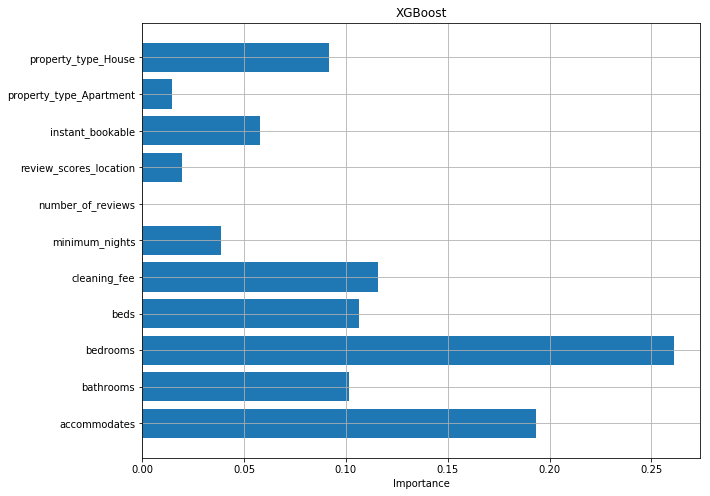

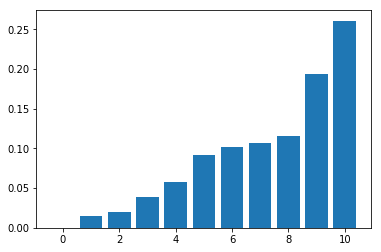

In [108]:
xgb.fit(X_train[:,selected_features],Y_train.reshape(-1,))
xgb_features = get_feature_ranking(xgb.feature_importances_)
print('XGB Features Ranking:',xgb_features)
plot_features_ranking(xgb.feature_importances_, 'XGBoost', selected_features)
# plot
pyplot.bar(range(len(xgb.feature_importances_)), sorted(xgb.feature_importances_))
pyplot.show()

### Predictions

In [9]:
xgb = XGBRegressor(booster='gbtree',gamma=0,learning_rate=0.1,colsample_bytree=0.8,subsample=0.7,min_child_weight=2,max_depth=2,n_estimators=70,n_jobs=-1,reg_alpha=1,silent=True)
xgb.fit(X_train[:,selected_features],Y_train)
Y_pred = xgb.predict(X_test[:,selected_features])

# Output to csv file
from pandas import DataFrame
y_p = {'id': np.arange(0,570),'price': Y_pred.reshape(-1,)}
y_p = DataFrame(y_p)
y_p.to_csv('XGBoost.csv', index=False)
Y_pred

array([100.25848 , 174.27834 ,  88.114746, 107.34847 , 233.17664 ,
       130.56302 , 347.17792 , 138.02745 , 135.39423 ,  71.92831 ,
       316.76624 , 144.38974 , 302.3412  , 165.42953 , 148.93433 ,
       281.0247  , 152.90402 , 231.30476 , 192.87227 , 152.90402 ,
       165.05585 , 225.28621 , 224.82346 , 256.014   ,  71.162544,
       121.677216,  66.62076 , 124.42175 ,  65.60525 , 168.95816 ,
       136.02254 , 220.75406 , 114.46507 , 185.4927  , 132.68338 ,
       110.47028 , 290.94418 , 107.10161 , 317.08255 , 105.545746,
       249.26503 , 131.73828 , 141.94519 , 100.472336, 156.22426 ,
       138.51971 , 187.55885 ,  75.05012 , 151.88506 , 159.99399 ,
       202.52692 , 141.94519 ,  65.60525 , 161.81064 ,  68.84205 ,
       279.19623 , 178.31912 , 353.70618 ,  54.255157,  90.49515 ,
       235.0873  , 106.44043 , 204.62349 , 137.66418 , 135.28291 ,
       131.73828 , 118.9813  ,  69.365295, 118.9813  , 207.08476 ,
       109.56224 , 240.75922 , 286.49783 , 125.28851 , 241.161